# Categorical VAE with Gumbel-Softmax

Partial implementation of the paper [Categorical Reparameterization with Gumbel-Softmax](https://arxiv.org/abs/1611.01144) 

Design of the VAE follows the implementation from https://github.com/ericjang/gumbel-softmax

## Imports and Helper Functions

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfpd
import pandas as pd

In [2]:
tf.__version__, tfp.__version__

('2.2.0', '0.9.0')

In [3]:
import sys
sys.path.append('../mdnf')

In [4]:
import aux
import time
import copy
import sys

## Configuration

In [5]:
# can be run as a script with args in format KEY=VAL,KEY=[STRVAL],...
args = aux.parse_script_args() 

In [6]:
SEED = args.get("SEED", 0)
OUT = args.get("OUT", "VAEConcrete.csv")

ST = bool(args.get("ST", 0))
LOSS = args.get("LOSS", 0) # which of the objectives to use (see ALG_NAME below)
N = args.get("N", 10) # how many latent variables
K = args.get("K", 2) # how many categories each

BASE_TEMP=args.get("BASE_TEMP", 1.0) # initial temperature
ANNEAL_RATE=args.get("ANNEAL_RATE", 0.00003)
MIN_TEMP=args.get("MIN_TEMP", 0.5)
PRIORS_TEMP=args.get("PRIORS_TEMP", 1.0)

OPTIMIZER = args.get("OPTIMIZER", "ADAM")
LR = args.get("LR", 0.001)
BATCH_SIZE=args.get("BATCH_SIZE", 256) # how many samples in minibatch
NUM_ITERS=args.get("NUM_ITERS", 2) # how many epochs

In [7]:
ALG_NAME = {0: "VAE_CONCRETE", 
            1: "VAE_CONCRETE_MADDISON21", 
            2: "VAE_CONCRETE_MADDISON22_JANG2", 
            3: "VAE_CONCRETE_JANG",
            4: "VAE_CONCRETE_CATPRIORS"}[LOSS]
CFG = [ALG_NAME, SEED, OUT, ST, N, K, BATCH_SIZE, NUM_ITERS, 
       BASE_TEMP, PRIORS_TEMP, OPTIMIZER, LR, ANNEAL_RATE, MIN_TEMP]
print("CFG=%s" % CFG)

CFG=['VAE_CONCRETE', 0, 'VAEConcrete.csv', False, 10, 2, 256, 100, 1.0, 1.0, 'ADAM', 0.001, 3e-05, 0.5]


## Straight-Through

In [8]:
@tf.function       
def straight_through_sample(y, hard=True):
  """
  Args:
    y: [..., n_class] one-hot sample from the Gumbel-Softmax distribution. 
    hard: if True, take argmax, but differentiate w.r.t. soft sample y
  Returns:
    If hard=True, then the returned sample y will be one-hot, otherwise it will
    be a probabilitiy distribution that sums to 1 across classes
  """
  if hard:
    K = y.shape[-1]
    y_hard = tf.cast(tf.one_hot(tf.argmax(y,-1), K), y.dtype)
    y = tf.stop_gradient(y_hard - y) + y  
  return y

## Model

In [9]:
class CategoricalVAE(tf.Module):

    def __init__(self, N, K, hard=False, name=None):
        """
        
            Args:
                N: number of variables
                K: number of categories for each variable
                hard: set hard=True for ST Gumbel-Softmax 
        """
        super(CategoricalVAE, self).__init__(name=name)

        self.N = N # number of categorical distributions
        self.K = K # number of classes
        self.hard = hard # set hard=True for ST Gumbel-Softmax 

        self.calc_logits_y = tf.keras.Sequential([ # encoder
                                             tf.keras.layers.Flatten(name="encoder0"),
                                             tf.keras.layers.Dense(512, activation="relu", 
                                                                   input_shape=(None, 784), name="encoder1"),
                                             tf.keras.layers.Dense(256, activation="relu", name="encoder2"),
                                             tf.keras.layers.Dense(K*N, activation=None, name="encoder3"),
                                             tf.keras.layers.Reshape( [N,K] , name="encoder4")
                                            ], name="encoder")

        self.calc_logits_x = tf.keras.Sequential( # decoder
                                            [tf.keras.layers.Flatten(name="decoder0"),
                                             tf.keras.layers.Dense(256, activation="relu", name="decoder1"),
                                             tf.keras.layers.Dense(512, activation="relu", name="decoder2"),
                                             tf.keras.layers.Dense(784, activation=None, name="decoder3"),
                                            ], name="decoder") 
         
    #@tf.function
    def __call__(self, x, temperature=5.0):
        tau = tf.constant(temperature, name="temperature", dtype=tf.float32)                        
        
        # variational posterior q(y|x), i.e. the encoder 
        # unnormalized logits for N separate K-categorical distributions (shape=(batch_size,N,K))
        logits_y = self.calc_logits_y(x)
        q_y = tfpd.RelaxedOneHotCategorical(tau, logits=logits_y)
        y = q_y.sample()
        y = straight_through_sample(y, self.hard) # set hard=True for ST Gumbel-Softmax

        # generative model p(x|y)
        logits_x = self.calc_logits_x(y)    
        p_x = tfpd.Bernoulli(logits=logits_x)
        
        return p_x, q_y, y, logits_y

## Train

In [10]:
# get data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path='mnist.npz')
frmt = lambda images: tf.cast(tf.reshape(images,(-1, 784)), tf.float32)/255.0
x_train, x_test = frmt(x_train), frmt(x_test)

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

In [11]:
OPTIMIZERS = {"RMS": tf.keras.optimizers.RMSprop,
              "ADAM": tf.keras.optimizers.Adam}
if OPTIMIZER not in OPTIMIZERS: raise ValueError("Unknown optimizer!")
optimizer_class = OPTIMIZERS[OPTIMIZER]
optimizer = optimizer_class(learning_rate=LR)

print("optimizer=%s lr=%s" % (optimizer, LR))

optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f83289f4a00> lr=0.001


In [13]:
def loss_relaxed_priors(x, p_x, q_y, y, *args, **kwargs): 
    """ For KL uses Monte Carlo KL with relaxed (concrete) prior. 
        The only variant resulting in a valid lower bound!
    
        The same as in (variant 1)
        https://github.com/ericjang/gumbel-softmax/blob/master/gumbel_softmax_vae_v2.ipynb
    """
    (batch_size, N), K = q_y.batch_shape, q_y.event_shape[0]
    
    #tau = q_y.temperature # use the same temperature for prior as for posterior 
    tau = PRIORS_TEMP
    logits_py = tf.ones_like(q_y.logits) * 1./K  #logits_py = tf.ones_like(logits_y) * 1./K
    p_y = tfpd.RelaxedOneHotCategorical(tau, logits=logits_py) # compare to Relaxed (concrete)

    KL_qp = q_y.log_prob(y+1e-20) - p_y.log_prob(y+1e-20) #MC estimate
    KL = tf.reduce_sum(KL_qp, 1)

    elbo = tf.reduce_sum(p_x.log_prob(x), 1) - KL        
    return tf.reduce_mean(-elbo) 

In [14]:
def loss_categorical_categorical_mc(x, p_x, q_y, y, *args, **kwargs):
    """ For KL uses MC KL with Categorical priors and converts q_y to categorical. 
    
        Described by Maddison et al. in Eq (21) in Appendix C.2
    """    
    (batch_size, N), K = q_y.batch_shape, q_y.event_shape[0]

    logits_py = tf.ones_like(q_y.logits) * 1./K  
    p_cat_y = tfpd.OneHotCategorical(logits=logits_py) # compare to categorical
    q_cat_y = tfpd.OneHotCategorical(logits=q_y.logits)
    KL_qp = q_cat_y.log_prob(y+1e-20)-p_cat_y.log_prob(y+1e-20)
    KL = tf.reduce_sum(KL_qp, 1)

    elbo = tf.reduce_sum(p_x.log_prob(x), 1) - KL        
    return tf.reduce_mean(-elbo)

In [15]:
def loss_categorical_categorical(x, p_x, q_y, y, *args, **kwargs):
    """ For KL uses analytical KL with Categorical priors and converts q_y to categorical. 
    
        Described by Maddison et al. in Eq (22) in Appendix C.2
        The same as in (variant 2)
        https://github.com/ericjang/gumbel-softmax/blob/master/gumbel_softmax_vae_v2.ipynb
    """    
    (batch_size, N), K = q_y.batch_shape, q_y.event_shape[0]

    #logits_py = tf.ones_like(logits_y) * 1./K
    #p_cat_y = OneHotCategorical(logits=logits_py)
    #q_cat_y = OneHotCategorical(logits=logits_y)
    #KL_qp = tf.contrib.distributions.kl(q_cat_y, p_cat_y)    
    #KL = tf.reduce_sum(KL_qp,1)
    
    logits_py = tf.ones_like(q_y.logits) * 1./K  
    p_cat_y = tfpd.OneHotCategorical(logits=logits_py) # compare to categorical
    q_cat_y = tfpd.OneHotCategorical(logits=q_y.logits)
    KL_qp = tfpd.kl_divergence(q_cat_y, p_cat_y)
    KL = tf.reduce_sum(KL_qp, 1)

    elbo = tf.reduce_sum(p_x.log_prob(x), 1) - KL        
    return tf.reduce_mean(-elbo)

In [16]:
def loss_Jang(x, p_x, q_y, y, logits_y, *args, **kwargs):
    """ For KL uses relaxed q and categorical priors.
    
        Following the loss used from the original implementation by Jang et al.:
        https://github.com/ericjang/gumbel-softmax/blob/master/Categorical%20VAE.ipynb
    """
    (batch_size, N), K = q_y.batch_shape, q_y.event_shape[0]

    q_y = tf.nn.softmax(logits_y) #q_y = tf.nn.softmax(logits_y)
    log_q_y = tf.math.log(q_y+1e-20) #log_q_y = tf.log(q_y+1e-20)       
    
    #kl_tmp = tf.reshape(q_y*(log_q_y-tf.log(1.0/K)),[-1,N,K])
    #KL = tf.reduce_sum(kl_tmp,[1,2])
    kl_tmp = tf.reshape(q_y*(log_q_y-tf.math.log(1.0/K)),[-1,N,K])
    KL = tf.reduce_sum(kl_tmp, [1,2])

    elbo = tf.reduce_sum(p_x.log_prob(x), 1) - KL 
    raise Exception("For Jang's loss use the low level implementation in VAEConcreteLowLevel!")
    return tf.reduce_mean(-elbo)

In [17]:
def loss_categorical_priors_mc(x, p_x, q_y, y, *args, **kwargs):
    """ For KL uses Monte Carlo KL with Categorical prior and relaxed q. 
    """    
    (batch_size, N), K = q_y.batch_shape, q_y.event_shape[0]

    logits_py = tf.ones_like(q_y.logits) * 1./K  
    p_cat_y = tfpd.OneHotCategorical(logits=logits_py) # compare to categorical

    KL = tf.reduce_sum(q_y.log_prob(y)-p_cat_y.log_prob(y), 1)

    elbo = tf.reduce_sum(p_x.log_prob(x), 1) - KL        
    return tf.reduce_mean(-elbo)

In [18]:
def true_loss(x, p_x, q_y, nsamples=1000, *args):
    (batch_size, N), K = q_y.batch_shape, q_y.event_shape[0]
    
    py = tf.reduce_mean(straight_through_sample(q_y.sample(nsamples)), 0)
    H_q = -tf.reduce_sum(py*np.log(py+1e-16), [-1,-2]) # sum over categories and then over independent variables

    #Eq_logp = np.sum(np.sum(np.ones((batch_size,N,K))*np.log(0.5), -1), -1)
    Eq_logp = np.sum(np.mean(np.ones((batch_size,N,K))*np.log(1/K), -1), -1)

    KL = -Eq_logp -H_q
    lik = tf.reduce_sum(p_x.log_prob(x), -1)
    return float(-tf.reduce_mean(lik)+tf.reduce_mean(KL))

In [19]:
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [20]:
vae = CategoricalVAE(N=N, K=K, hard=ST)
results = []
best_loss, best_vae = float("inf"), None
start = time.time()
i = 0
np_temp=BASE_TEMP

In [21]:
loss = {
        0: loss_relaxed_priors, 
        1: loss_categorical_categorical_mc, 
        2: loss_categorical_categorical, 
        3: loss_Jang,
        4: loss_categorical_priors_mc,
}[LOSS]
print("loss = %s" % loss)

loss = <function loss_relaxed_priors at 0x7f83289ed700>


In [22]:
for e in range(NUM_ITERS):

    losses, true_losses = [], []
    for np_x, labels in train_ds:
        
        with tf.GradientTape() as tape:        
            p_x, q_y, y, logits_y = vae(np_x, temperature=np_temp)
            l = loss(np_x, p_x, q_y, y, logits_y)
        losses.append( float(l) ); 
        tl = true_loss(np_x, p_x, q_y)
        true_losses.append( float(tl) )
        g = tape.gradient(l, vae.trainable_variables)
        optimizer.apply_gradients(zip(g, vae.trainable_variables))
        
        if i % 1000 == 1: # following Jang's code
            np_temp = np.maximum(BASE_TEMP*np.exp(-ANNEAL_RATE*i), MIN_TEMP)
            
        i += 1
        if i%100==0 or i<10: 
            print("[%.1fs] epoch=%i/iteration=%i loss=%.2f ELBO=%.2f" % \
                  (time.time()-start, e, i, l, -tl))               
    ########################################################################
    
    if np.mean(losses)<best_loss:
        best_loss = np.mean(losses)
        try: 
            best_vae = copy.deepcopy(vae)
        except Exception as exc:
            if best_vae is None:
                    print("[ERROR] Failed to copy VAE object as best_vae: %s" % exc)
            best_vae = vae                
            
    print ("[%.1fs] %d. l=%.2f (best=%.2f) ELBO=%.2f t=%.2f" % (time.time()-start, 
            e, np.mean(losses), best_loss, -np.mean(true_losses), np_temp))                        
    results.append(CFG+[time.time()-start, 
            e, np.mean(losses), best_loss, np.mean(true_losses), np_temp])
    sys.stdout.flush()
    
    print("Saving to %s" % OUT)
    pd.DataFrame(results).to_csv(OUT, header=False, index=False)    

[0.5s] epoch=0/iteration=1 loss=545.00 ELBO=-544.98
[0.6s] epoch=0/iteration=2 loss=535.26 ELBO=-535.04
[0.8s] epoch=0/iteration=3 loss=524.28 ELBO=-524.12
[0.9s] epoch=0/iteration=4 loss=510.84 ELBO=-510.48
[1.0s] epoch=0/iteration=5 loss=493.42 ELBO=-492.73
[1.2s] epoch=0/iteration=6 loss=472.72 ELBO=-470.60
[1.3s] epoch=0/iteration=7 loss=443.24 ELBO=-440.92
[1.4s] epoch=0/iteration=8 loss=415.89 ELBO=-410.10
[1.6s] epoch=0/iteration=9 loss=383.06 ELBO=-376.69
[14.0s] epoch=0/iteration=100 loss=196.88 ELBO=-195.48
[27.9s] epoch=0/iteration=200 loss=191.39 ELBO=-189.98
[32.8s] 0. l=211.13 (best=211.13) ELBO=-209.73 t=1.00
Saving to VAEConcrete.csv
[41.8s] epoch=1/iteration=300 loss=170.58 ELBO=-166.06
[55.7s] epoch=1/iteration=400 loss=166.11 ELBO=-159.08
[65.6s] 1. l=173.84 (best=173.84) ELBO=-168.59 t=1.00
Saving to VAEConcrete.csv
[69.9s] epoch=2/iteration=500 loss=159.31 ELBO=-152.78
[84.2s] epoch=2/iteration=600 loss=161.68 ELBO=-152.77
[98.5s] epoch=2/iteration=700 loss=151.54 

Saving to VAEConcrete.csv
[1199.9s] epoch=36/iteration=8500 loss=147.69 ELBO=-130.64
[1214.2s] epoch=36/iteration=8600 loss=144.16 ELBO=-128.14
[1227.5s] 36. l=145.83 (best=145.06) ELBO=-129.66 t=0.79
Saving to VAEConcrete.csv
[1228.2s] epoch=37/iteration=8700 loss=148.10 ELBO=-132.00
[1241.8s] epoch=37/iteration=8800 loss=144.77 ELBO=-128.75
[1255.2s] epoch=37/iteration=8900 loss=137.69 ELBO=-121.97
[1259.1s] 37. l=145.59 (best=145.06) ELBO=-129.37 t=0.79
Saving to VAEConcrete.csv
[1269.0s] epoch=38/iteration=9000 loss=138.65 ELBO=-123.88
[1282.7s] epoch=38/iteration=9100 loss=144.62 ELBO=-127.72
[1291.4s] 38. l=145.99 (best=145.06) ELBO=-129.46 t=0.76
Saving to VAEConcrete.csv
[1296.2s] epoch=39/iteration=9200 loss=145.67 ELBO=-129.62
[1309.7s] epoch=39/iteration=9300 loss=147.80 ELBO=-131.11
[1323.2s] epoch=39/iteration=9400 loss=145.14 ELBO=-126.48
[1323.2s] 39. l=146.35 (best=145.06) ELBO=-129.53 t=0.76
Saving to VAEConcrete.csv
[1337.0s] epoch=40/iteration=9500 loss=142.17 ELBO=-

[2330.1s] 72. l=152.32 (best=145.06) ELBO=-129.75 t=0.60
Saving to VAEConcrete.csv
[2336.0s] epoch=73/iteration=17200 loss=147.78 ELBO=-126.12
[2349.0s] epoch=73/iteration=17300 loss=152.82 ELBO=-131.05
[2360.3s] 73. l=152.65 (best=145.06) ELBO=-129.98 t=0.60
Saving to VAEConcrete.csv
[2361.7s] epoch=74/iteration=17400 loss=150.45 ELBO=-126.70
[2374.4s] epoch=74/iteration=17500 loss=148.70 ELBO=-125.67
[2387.1s] epoch=74/iteration=17600 loss=153.62 ELBO=-131.75
[2390.3s] 74. l=152.77 (best=145.06) ELBO=-129.93 t=0.60
Saving to VAEConcrete.csv
[2400.2s] epoch=75/iteration=17700 loss=146.80 ELBO=-124.74
[2412.9s] epoch=75/iteration=17800 loss=151.86 ELBO=-129.87
[2420.4s] 75. l=152.55 (best=145.06) ELBO=-129.80 t=0.60
Saving to VAEConcrete.csv
[2425.7s] epoch=76/iteration=17900 loss=151.24 ELBO=-128.24
[2438.5s] epoch=76/iteration=18000 loss=149.16 ELBO=-126.23
[2450.4s] 76. l=153.18 (best=145.06) ELBO=-130.01 t=0.58
Saving to VAEConcrete.csv
[2451.1s] epoch=77/iteration=18100 loss=157.2

In [23]:
vae = best_vae

## reconstruction

In [24]:
from matplotlib import pyplot as plt

In [25]:
np_x1 = x_train[-BATCH_SIZE:]

In [27]:
p_x, q_y, y, logits_y = vae(np_x1)
np_x2 = p_x.mean()

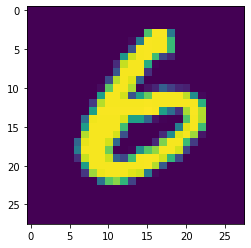

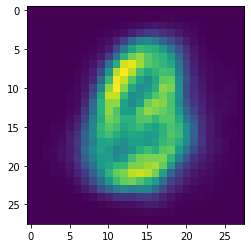

In [28]:
i = 31

plt.imshow(np_x1[i].numpy().reshape((28,28))); plt.show()
plt.imshow(np_x2[i].numpy().reshape((28,28))); plt.show()

## Unconditional Generation

This consists of sampling from the prior $p_\theta(y)$ and passing it through the generative model.

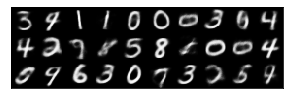

In [29]:
np.random.seed(0)
ys = []
for _ in range(3):
    xs = []
    for _ in range(10):
        np_y = np.zeros((N,K))
        np_y[range(N),np.random.choice(K,N)] = 1
        np_y = np.reshape(np_y,[1,N,K])

        logits_x = vae.calc_logits_x(tf.constant(np_y, dtype=tf.float32)) 
        p_x = tfp.distributions.Bernoulli(logits=logits_x)
        np_x = p_x.mean().numpy()[0].reshape((28,28))
        xs.append(np_x)
    ys.append(np.hstack(xs))
img = np.vstack(ys)   

fig = plt.figure(figsize=(6.4, 1.5), dpi=72)
plt.imshow(img, cmap=plt.cm.gray,interpolation='none')
plt.xticks([],{})
plt.yticks([],{})
plt.savefig("vae_concrete_nost.pdf", bbox_inches = 'tight', pad_inches =0)

In [30]:
M=100*N
np_y = np.zeros((M,K))
np_y[range(M),np.random.choice(K,M)] = 1
np_y = np.reshape(np_y,[100,N,K])

In [31]:
logits_x = vae.calc_logits_x(tf.constant(np_y, dtype=tf.float32)) 
p_x = tfp.distributions.Bernoulli(logits=logits_x)
np_x = p_x.mean().numpy()

In [32]:
np_y = np_y.reshape((10,10,N,K))
np_y = np.concatenate(np.split(np_y,10,axis=0),axis=3)
np_y = np.concatenate(np.split(np_y,10,axis=1),axis=2)
y_img = np.squeeze(np_y)

In [33]:
np_x = np_x.reshape((10,10,28,28))
# split into 10 (1,10,28,28) images, concat along columns -> 1,10,28,280
np_x = np.concatenate(np.split(np_x,10,axis=0),axis=3)
# split into 10 (1,1,28,280) images, concat along rows -> 1,1,280,280
np_x = np.concatenate(np.split(np_x,10,axis=1),axis=2)
x_img = np.squeeze(np_x)

Text(0.5, 1.0, 'Generated Images')

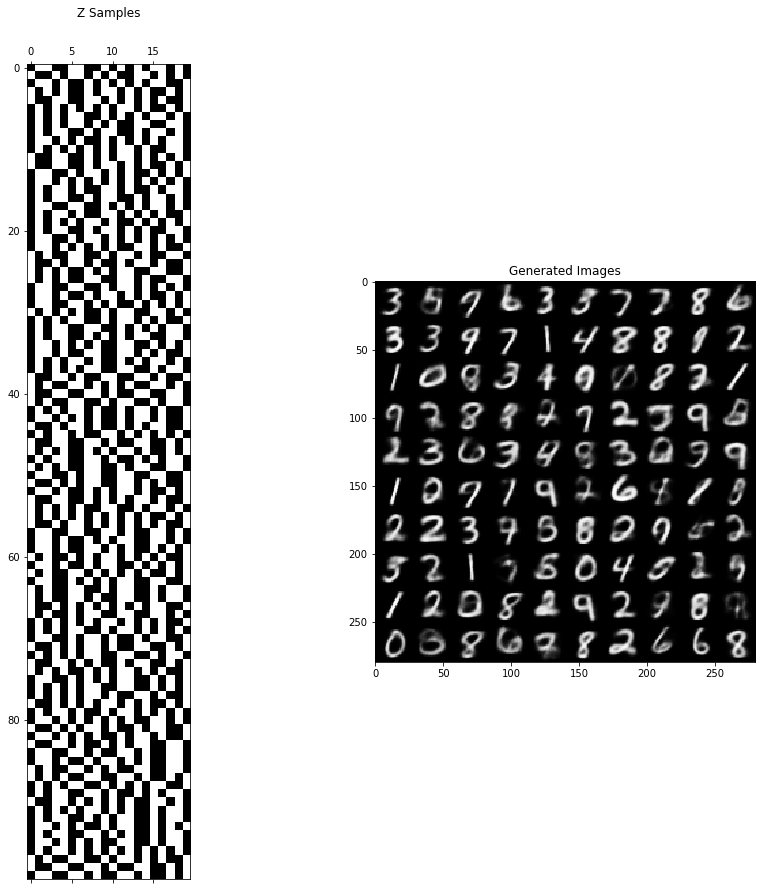

In [34]:
f,axarr=plt.subplots(1,2,figsize=(15,15))
# samples
axarr[0].matshow(y_img,cmap=plt.cm.gray)
axarr[0].set_title('Z Samples')
# reconstruction
axarr[1].imshow(x_img,cmap=plt.cm.gray,interpolation='none')
axarr[1].set_title('Generated Images')